# PRE-PROCESSING RESULTS ANALYSIS

Notebook finalizzato ad eseguire una diagnosi completa della qualità dei dati pre-processati (prima di passare al training dei modelli).

### Import librerie

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
# Configurazione
processed_dir = '../data/processed'
patients = [p for p in os.listdir(processed_dir) if p.startswith('TCGA')]
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### 1. ANALISI CAMPIONE CASUALE

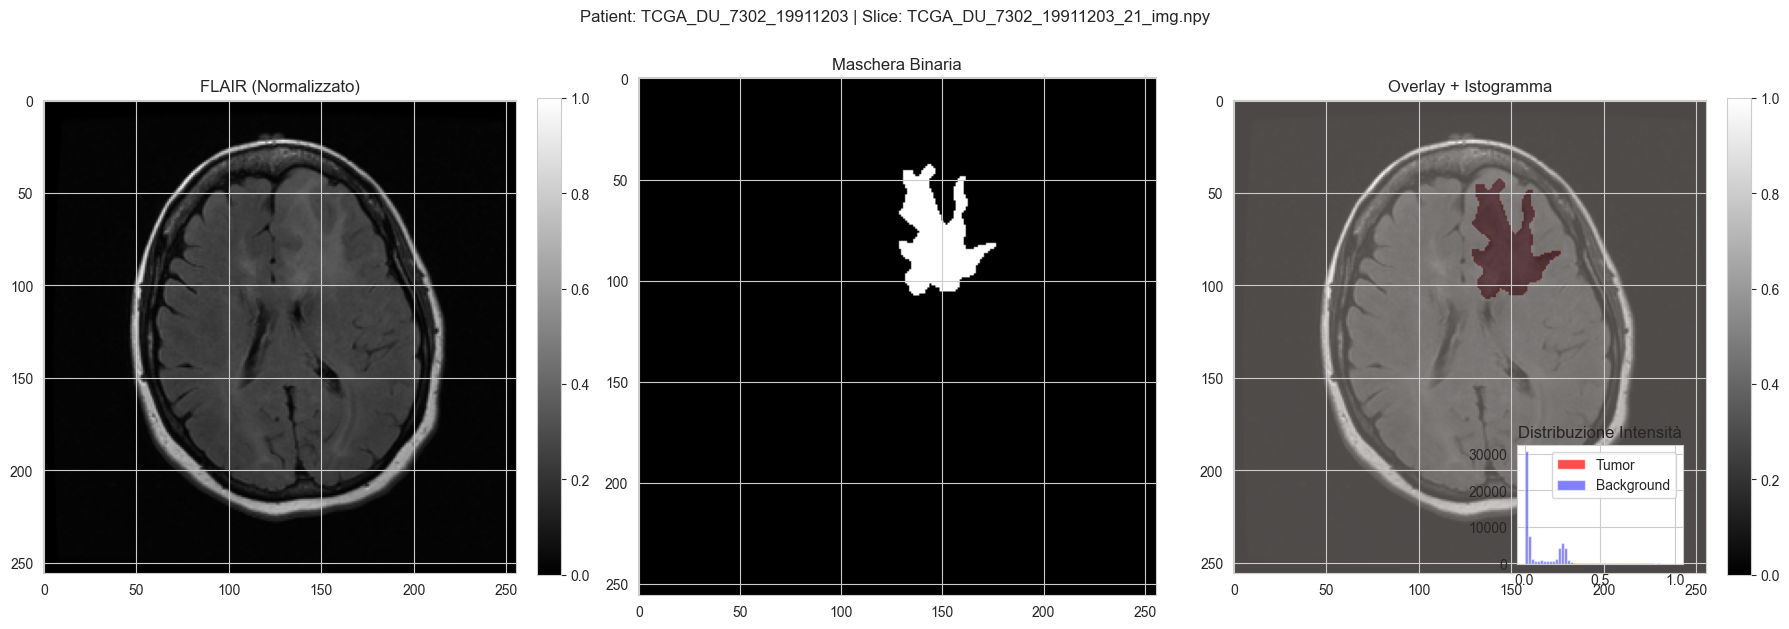


=== STATISTICHE CAMPIONE ===
Dimensioni: (1, 256, 256) (C, H, W)
Maschera - Valori unici: [0 1]
Intensità FLAIR - Globali: μ=0.114 ± 0.142
Intensità FLAIR - Tumor: μ=0.316 ± 0.026
Intensità FLAIR - Background: μ=0.109 ± 0.140
Area tumorale: 2.39% della slice


In [14]:
def plot_random_sample():
    patient = random.choice(patients)
    sample_file = random.choice([
        f for f in os.listdir(os.path.join(processed_dir, patient)) 
            if '_img.npy' in f
    ])
    
    img = np.load(os.path.join(processed_dir, patient, sample_file))
    mask = np.load(os.path.join(processed_dir, patient, sample_file.replace('_img', '_mask')))
    
    # Plot avanzato
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # Immagine FLAIR
    im0 = ax[0].imshow(img[0], cmap='gray')
    ax[0].set_title('FLAIR (Normalizzato)')
    plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)
    
    # Maschera
    ax[1].imshow(mask[0], cmap='gray')
    ax[1].set_title('Maschera Binaria')
    
    # Overlay con istogramma
    ax[2].imshow(img[0], cmap='gray')
    ax[2].imshow(mask[0], alpha=0.3, cmap='Reds')
    ax[2].set_title('Overlay + Istogramma')
    
    # Aggiungi istogramma
    fig.colorbar(im0, ax=ax[2], fraction=0.046, pad=0.04)
    ax2_hist = ax[2].inset_axes([0.6, 0.02, 0.35, 0.25])
    ax2_hist.hist(img[mask > 0.5], bins=50, alpha=0.7, color='red', label='Tumor')
    ax2_hist.hist(img[mask <= 0.5], bins=50, alpha=0.5, color='blue', label='Background')
    ax2_hist.legend()
    ax2_hist.set_title('Distribuzione Intensità')
    
    plt.suptitle(f"Patient: {patient} | Slice: {sample_file}", y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Statistiche avanzate
    tumor_pixels = img[mask > 0.5]
    bg_pixels = img[mask <= 0.5]
    
    print("\n=== STATISTICHE CAMPIONE ===")
    print(f"Dimensioni: {img.shape} (C, H, W)")
    print(f"Maschera - Valori unici: {np.unique(mask)}")
    print(f"Intensità FLAIR - Globali: μ={img.mean():.3f} ± {img.std():.3f}")
    print(f"Intensità FLAIR - Tumor: μ={tumor_pixels.mean():.3f} ± {tumor_pixels.std():.3f}")
    print(f"Intensità FLAIR - Background: μ={bg_pixels.mean():.3f} ± {bg_pixels.std():.3f}")
    print(f"Area tumorale: {100*mask.mean():.2f}% della slice")

plot_random_sample()

### 2. STATISTICHE GLOBALI DEL DATASET

Analisi dataset: 100%|██████████| 100/100 [00:00<00:00, 201.55it/s]


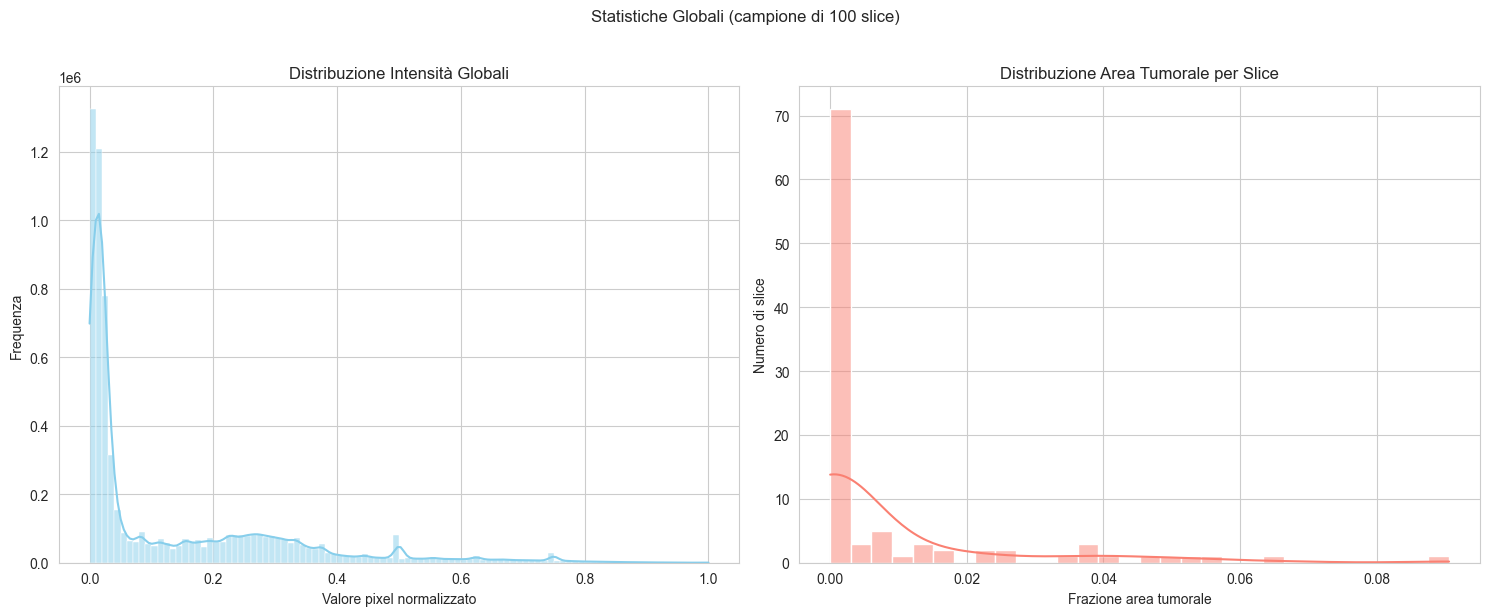


=== STATISTICHE GLOBALI ===
Intensità mediana (tutto il dataset): 0.030
Intensità tumorale mediana: 0.436
Area tumorale media per slice: 0.78%
Slice con >50% area tumorale: 0.00%


In [5]:
def analyze_dataset():
    # Inizializza accumulatori
    all_intensities = []
    tumor_intensities = []
    tumor_areas = []
    
    # Campiona 100 slice casuali per efficienza
    sample_slices = []
    for _ in range(100):
        p = random.choice(patients)
        s = random.choice([
            f for f in os.listdir(os.path.join(processed_dir, p)) 
                if '_img.npy' in f
        ])
        sample_slices.append((p, s))
    
    # Calcola statistiche
    for p, s in tqdm(sample_slices, desc="Analisi dataset"):
        img = np.load(os.path.join(processed_dir, p, s))
        mask = np.load(os.path.join(processed_dir, p, s.replace('_img', '_mask')))
        
        all_intensities.extend(img.ravel())
        tumor_intensities.extend(img[mask > 0.5].ravel())
        tumor_areas.append(mask.mean())
    
    # Plot distribuzioni
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Distribuzione intensità
    sns.histplot(all_intensities, bins=100, kde=True, ax=ax1, color='skyblue')
    ax1.set_title('Distribuzione Intensità Globali')
    ax1.set_xlabel('Valore pixel normalizzato')
    ax1.set_ylabel('Frequenza')
    
    # Percentuale area tumorale
    sns.histplot(tumor_areas, bins=30, kde=True, ax=ax2, color='salmon')
    ax2.set_title('Distribuzione Area Tumorale per Slice')
    ax2.set_xlabel('Frazione area tumorale')
    ax2.set_ylabel('Numero di slice')
    
    plt.suptitle("Statistiche Globali (campione di 100 slice)", y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Statistiche numeriche
    print("\n=== STATISTICHE GLOBALI ===")
    print(f"Intensità mediana (tutto il dataset): {np.median(all_intensities):.3f}")
    print(f"Intensità tumorale mediana: {np.median(tumor_intensities):.3f}")
    print(f"Area tumorale media per slice: {100*np.mean(tumor_areas):.2f}%")
    print(f"Slice con >50% area tumorale: {100*np.mean(np.array(tumor_areas) > 0.5):.2f}%")

analyze_dataset()

### 3. ANALISI PER PAZIENTE

Analisi pazienti: 100%|██████████| 20/20 [00:00<00:00, 116.06it/s]


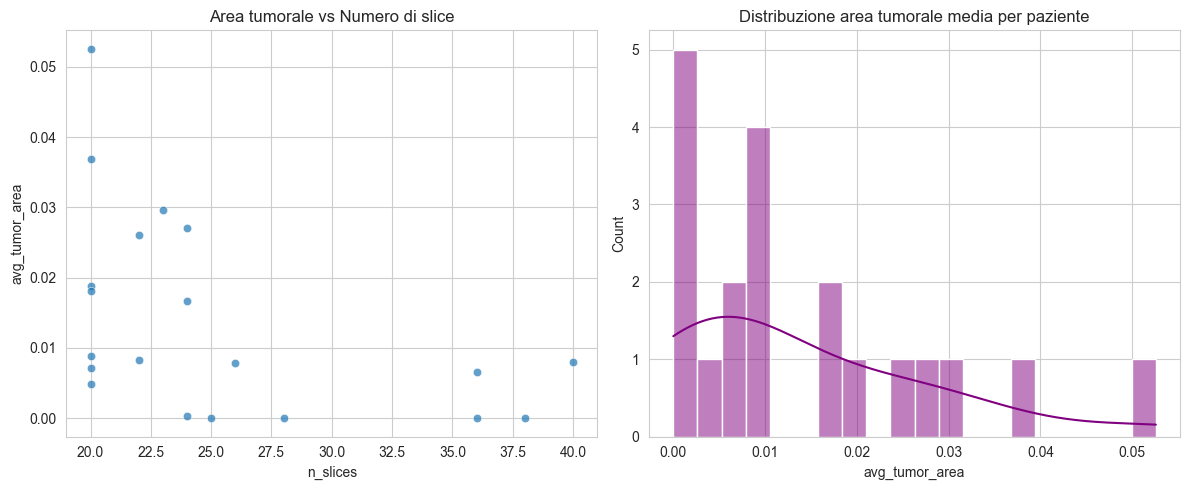

,avg_tumor_area,n_slices
count,20.000000,20.000000
mean,0.013889,25.400000
std,0.014340,6.660172
min,0.000000,20.000000
25%,0.003716,20.000000
50%,0.008127,23.500000
75%,0.020602,26.500000
max,0.052579,40.000000


In [6]:
def analyze_patient_stats():
    patient_stats = []
    
    for p in tqdm(patients[:20], desc="Analisi pazienti"):  # Limita a 20 pazienti per efficienza
        slices = [
            f for f in os.listdir(os.path.join(processed_dir, p)) 
                if '_img.npy' in f
        ]
        tumor_areas = []
        
        for s in slices[:5]:  # Campiona max 5 slice per paziente
            mask = np.load(os.path.join(processed_dir, p, s.replace('_img', '_mask')))
            tumor_areas.append(mask.mean())
        
        patient_stats.append({
            'patient': p,
            'avg_tumor_area': np.mean(tumor_areas),
            'n_slices': len(slices)
        })
    
    # Converti in DataFrame per analisi
    import pandas as pd
    df_stats = pd.DataFrame(patient_stats)
    
    # Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    sns.scatterplot(data=df_stats, x='n_slices', y='avg_tumor_area', alpha=0.7)
    plt.title('Area tumorale vs Numero di slice')
    
    plt.subplot(122)
    sns.histplot(df_stats['avg_tumor_area'], bins=20, kde=True, color='purple')
    plt.title('Distribuzione area tumorale media per paziente')
    
    plt.tight_layout()
    plt.show()
    
    return df_stats

df_patient_stats = analyze_patient_stats()
display(df_patient_stats.describe())